Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [85]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [87]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [88]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
import numpy as np

In [90]:
print(train.shape)
train.head()


(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [91]:
print(test.shape)
test.head()

(14358, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [0]:
# gps_height has a lot of Zero values... those could possibly have been meant to 
# be null values, for now we will leave them, but could come back and change to Null

# lattitude has values that are really close to 0, but no actuall zeros. Seeing as how 
# tanzania does not sit at zero lattitude those should probably be null values that we will
# have to impute

# num private has almost all zeros as values, and the feature information from kaggle
# doesnt indicate what this information is so probably we can drop this feature.
# once we have run preliminary tests and seen what the coefficients are maybe we can 
# come back and drop this feature.

# population...There are a lot of zeros in this. THat could be because the areas that there 
# are waterpumps dont have an actual population. SO, we will leave this as is. 
# we can come back and research the areas that have 0 for population and see if those
# areas actually do have zero populations. 



### Do train/validate/test split with the Tanzania Waterpumps data.

In [0]:
from sklearn.model_selection import train_test_split

# split the train set into a training and validation set. Will use a 75% for 
# the training set and 25% for the validation set

train, val = train_test_split(train, train_size=.75, test_size=.25,
                              stratify=train['status_group'], random_state=42)

In [93]:
print('Dimensions of train set: ', train.shape)
print('Dimensions of validation set: ', val.shape)

print('% observations in train set: ', train.shape[0]/(train.shape[0] + val.shape[0]))

Dimensions of train set:  (44550, 41)
Dimensions of validation set:  (14850, 41)
% observations in train set:  0.75


In [0]:
# function to clean up subsests in the same way. 

def wrangle(X):

  # set copy
  X = X.copy()

  # Quantity and quantity_group are duplicates so we can drop one. 
  X = X.drop(columns='quantity_group')

  # update the latitude numberst that are close to zero to be equal to zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # update the columns that have zeros and shouldnt, we will replace the zero
  # with a null value.
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  return X

In [95]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

print('dimensions of train set is: ', train.shape)
print('dimensions of validation set is: ', val.shape)
print('dimensions of test set is: ', test.shape)

dimensions of train set is:  (44550, 40)
dimensions of validation set is:  (14850, 40)
dimensions of test set is:  (14358, 39)


### Begin with baselines for classification

In [96]:
# find the majority class of the target - 'status_group;

train['status_group'].value_counts(normalize=True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

### Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
# get high cardinality features by setting a limit on the number of unique items
# that we want. From the above pandas profiling, about 30 is the max that we will 
# want. We will exclude categorical features with more than 30 unique values from our
# features. But before we do that we will change a few columns to include the top 29
# areas for the features 'lga' and 'ward', anything outside of the top 29 we will
# make 'Other'


# Reduce cardinality for 'lga' and 'ward' feature ...

def reduce_cardinality(X):
  lga_top = X['lga'].value_counts()[:29].index
  ward_top = X['ward'].value_counts()[:29].index

  X.loc[~X['lga'].isin(lga_top), 'lga'] = 'other'
  X.loc[~X['ward'].isin(ward_top), 'ward'] = 'other'

  return X



In [0]:
train = reduce_cardinality(train)
val = reduce_cardinality(val)
test = reduce_cardinality(test)

In [100]:
print(len(train['ward'].value_counts()))
print(len(val['ward'].value_counts()))
print(len(test['ward'].value_counts()))

30
30
30


In [101]:
# target == 'status_group'. this is what we want to predict
target = 'status_group'

# get all the columns except fro the target and the id.
train_features = train.drop(columns=[target, 'id'])

# list of all the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get series of the nonnumeric features with the corresponding cardinality of each
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of categorical features with less than 50 unique datapoints
categorical_features = cardinality[cardinality <= 50].index.tolist()

# combine the numeric and the categorical lists
features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# set the X features matrix and the y target vector for the train, val, and test sets

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

#### Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [105]:
# use pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)       
)

# fit the pipeline to the training set
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'lga', 'ward',
                                     'public_meeting', 'recorded_by',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'sourc...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                   

#### Get your validation accuracy score.

In [107]:
print('Training accuracy is: ', pipeline.score(X_train, y_train))
print('Validation accuracy is: ', pipeline.score(X_val, y_val))

Training accuracy is:  0.9954882154882155
Validation accuracy is:  0.7507744107744108


### Get and plot your feature importances.

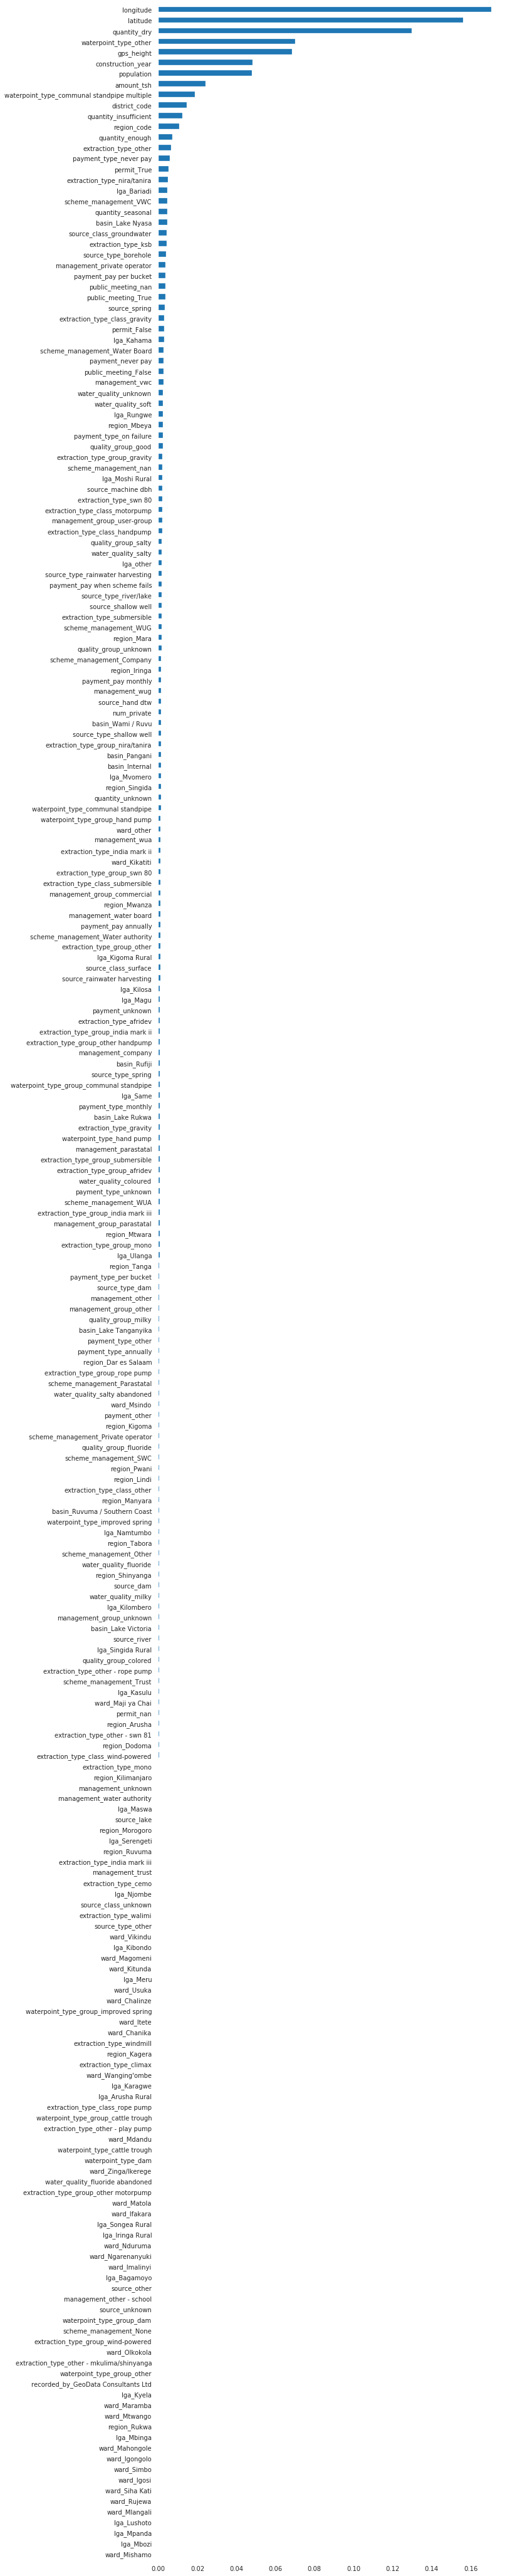

In [111]:

import matplotlib.pyplot as plt
%matplotlib inline

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize = (10, 75))
importances.sort_values().plot.barh()

In [0]:
# looks like the 'lga' and the 'ward' features that we filtered down didnt 
# have much affect on the importance of the model. 

### Initially we didnt adjust the min_leaf parameter so we are very overfit on our model. Lets adjust that and see if we can improve the accuracy score on the validation set before we run a final on our Test set

In [113]:
# use pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=25)       
)

# fit the pipeline to the training set
pipeline.fit(X_train, y_train)

print('Training accuracy is: ', pipeline.score(X_train, y_train))
print('Validation accuracy is: ', pipeline.score(X_val, y_val))

Training accuracy is:  0.7983164983164983
Validation accuracy is:  0.7600673400673401


In [118]:
# lets use a for loop to cycle and print the results from a few different itterations

sample_size = [5, 10, 15, 16, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30]

for sample in sample_size:
  pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=sample)       
)

  # fit the pipeline to the training set
  pipeline.fit(X_train, y_train)

  print('min_samples_leaf: ', sample)
  print('Training accuracy is: ', pipeline.score(X_train, y_train))
  print('Validation accuracy is: ', pipeline.score(X_val, y_val))
  print('__'*30)
  print('\n')
 


min_samples_leaf:  5
Training accuracy is:  0.8744556677890011
Validation accuracy is:  0.7673400673400673
____________________________________________________________


min_samples_leaf:  10
Training accuracy is:  0.8341638608305275
Validation accuracy is:  0.7698316498316499
____________________________________________________________


min_samples_leaf:  15
Training accuracy is:  0.8173961840628508
Validation accuracy is:  0.7678114478114478
____________________________________________________________


min_samples_leaf:  16
Training accuracy is:  0.8151739618406285
Validation accuracy is:  0.7669360269360269
____________________________________________________________


min_samples_leaf:  17
Training accuracy is:  0.8127048260381594
Validation accuracy is:  0.765993265993266
____________________________________________________________


min_samples_leaf:  18
Training accuracy is:  0.8103030303030303
Validation accuracy is:  0.7653872053872054
_______________________________________

It looks like a min sample leaf on 19 saw the best validation accuracy score. 

### What if we reduced all features to the top 45. that way all features are used in the predications. Could we increase our accuracy?


In [121]:
set(train.columns) - set(X_train.columns)

{'date_recorded',
 'funder',
 'id',
 'installer',
 'scheme_name',
 'status_group',
 'subvillage',
 'wpt_name'}

In [132]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,43195.000000,43195.000000,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37014.537755,324.898325,669.616094,35.149387,-5.894747,0.485140,15.252391,5.607250,179.684085,1302.070011
std,21402.267757,3281.228067,693.047465,2.604521,2.805091,13.683636,17.541883,9.597167,462.207597,951.166321
min,0.000000,0.000000,-63.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18449.250000,0.000000,0.000000,33.284617,-8.647581,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36966.500000,0.000000,372.000000,35.011547,-5.186215,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55374.250000,25.000000,1320.000000,37.224180,-3.378256,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-0.998464,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [0]:
Categorical_features = train.select_dtypes(exclude='number').columns.tolist()

In [0]:


def reduce_cardinality(X):
  lga_top = X['lga'].value_counts()[:29].index
  ward_top = X['ward'].value_counts()[:29].index
  wpt_name_top = X['wpt_name'].value_counts()[:50]
  sub_village_top = X['subvillage'].value_counts()[:100]

  X.loc[~X['lga'].isin(lga_top), 'lga'] = 'other'
  X.loc[~X['ward'].isin(ward_top), 'ward'] = 'other'
  X.loc[~X['wpt_name'].isin(wpt_name_top), 'wpt_name'] = 'other'
  X.loc[~X['subvillage'].isin(sub_village_top), 'subvillage'] = 'other'

  return X


In [0]:
train = reduce_cardinality(train)
val = reduce_cardinality(val)
test = reduce_cardinality(test)

In [135]:
# target == 'status_group'. this is what we want to predict
target = 'status_group'

# get all the columns except fro the target and the id.
train_features = train.drop(columns=[target, 'id'])

# list of all the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get series of the nonnumeric features with the corresponding cardinality of each
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of categorical features with less than 50 unique datapoints
categorical_features = cardinality[cardinality <= 50].index.tolist()

# combine the numeric and the categorical lists
features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# set the X features matrix and the y target vector for the train, val, and test sets

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [140]:
# Set pipeline using the min_samples_leaf of 19


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=19)       
)

# fit the pipeline to the training set
pipeline.fit(X_train, y_train)

print('Training accuracy is: ', pipeline.score(X_train, y_train))
print('Validation accuracy is: ', pipeline.score(X_val, y_val))

Training accuracy is:  0.8078114478114478
Validation accuracy is:  0.7672727272727272


In [0]:
# lets run this on the Test data. 

y_pred = pipeline.predict(X_test)

In [0]:
submission = test[['id']].copy()
submission['status_group'] = y_pred

In [0]:
submission.to_csv('water_pumps.csv', index=False)

In [0]:
submission

In [0]:
# # what if we use our logicistic regression CV model?
# # can we improve our accuracy?
# from sklearn.linear_model import LogisticRegressionCV

# pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     SimpleImputer(strategy='mean'),
#     StandardScaler(),
#     LogisticRegressionCV()       
# )


# pipeline.fit(X_train, y_train)

# print('Training accuracy is: ', pipeline.score(X_train, y_train))
# print('Validation accuracy is: ', pipeline.score(X_val, y_val))

# # this particular model didnt improve the accuracy. 

In [0]:
#